In [ ]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable


eSOH_DIR = "./data/esoh_R/"
oCV_DIR = "./data/ocv/"
fig_DIR = "./figures_fit/"
res_DIR = "./data/results_fit/"
# %matplotlib widget

In [ ]:
plt.rcParams["lines.markersize"] = 5
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["font.size"] = 12
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["legend.frameon"] = False
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.it'] = 'serif:italic'
plt.rcParams['mathtext.bf'] = 'serif:bold'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.color"] = (0.8, 0.8, 0.8)
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.max_open_warning']=False

In [ ]:
def nmc_volume_change_mohtat(sto):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change_mohtat(sto):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    return t_change

def get_parameter_values():
    parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
    parameter_values.update(
        {
            # mechanical properties
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0
        },
        check_already_exists=False,
    )
    return parameter_values
parameter_values = get_parameter_values()

In [ ]:
def split_long_string(title, max_words=None):
    """Get title in a nice format"""
    max_words = max_words or pybamm.settings.max_words_in_line
    words = title.split()
    # Don't split if fits on one line, don't split just for units
    if len(words) <= max_words or words[max_words].startswith("["):
        return title
    else:
        first_line = (" ").join(words[:max_words])
        second_line = (" ").join(words[max_words:])
        return first_line + "\n" + second_line

In [ ]:
def cycle_adaptive_simulation(model, parameter_values, experiment,SOC_0=1, save_at_cycles=None):
    experiment_one_cycle = pybamm.Experiment(
        experiment.operating_conditions_cycles[:1],
        termination=experiment.termination_string,
        cccv_handling=experiment.cccv_handling,
    )
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = parameter_values.evaluate(param.C_n_init)
    Cp = parameter_values.evaluate(param.C_p_init)
    eps_n = parameter_values["Negative electrode active material volume fraction"]
    eps_p = parameter_values["Positive electrode active material volume fraction"]
    C_over_eps_n = Cn / eps_n
    C_over_eps_p = Cp / eps_p
    c_n_max = parameter_values.evaluate(param.c_n_max)
    c_p_max = parameter_values.evaluate(param.c_p_max)
    n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
    
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
                "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            
        }
    )

    sim_ode = pybamm.Simulation(
        model, experiment=experiment_one_cycle, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol0 = sim_ode.solve(initial_soc=SOC_0)
    model = sim_ode.solution.all_models[0]
    cap0 = sol0.summary_variables["Capacity [A.h]"]

    def sol_to_y(sol, loc="end"):
        if loc == "start":
            pos = 0
        elif loc == "end":
            pos = -1
        model = sol.all_models[0]
        n_Li = sol["Total lithium in particles [mol]"].data[pos].flatten()
        Cn = sol["Negative electrode capacity [A.h]"].data[pos].flatten()
        Cp = sol["Positive electrode capacity [A.h]"].data[pos].flatten()
        # y = np.concatenate([n_Li, Cn, Cp])
        y = n_Li
        for var in model.initial_conditions:
            if var.name not in [
                "X-averaged negative particle concentration",
                "X-averaged positive particle concentration",
                "Discharge capacity [A.h]",
            ]:
                value = sol[var.name].data
                if value.ndim == 1:
                    value = value[pos]
                elif value.ndim == 2:
                    value = value[:, pos]
                elif value.ndim == 3:
                    value = value[:, :, pos]
                y = np.concatenate([y, value.flatten()])
        return y

    def y_to_sol(y, esoh_sim, model):
        n_Li = y[0]
        Cn = C_over_eps_n * y[1]
        Cp = C_over_eps_p * y[2]

        esoh_sol = esoh_sim.solve(
            [0],
            inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
        )
        esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
        ics = {}
        x_100 = esoh_sol["x_100"].data[0]
        y_100 = esoh_sol["y_100"].data[0]
        x_0 = esoh_sol["x_0"].data[0]
        y_0 = esoh_sol["y_0"].data[0]
        start = 1
        for var in model.initial_conditions:
            if var.name == "X-averaged negative particle concentration":
                ics[var.name] = ((x_100-x_0)*SOC_0+x_0) * np.ones((model.variables[var.name].size, 2))
            elif var.name == "X-averaged positive particle concentration":
                ics[var.name] = y_100 * np.ones((model.variables[var.name].size, 2))
            elif var.name == "Discharge capacity [A.h]":
                ics[var.name] = np.zeros(1)
            else:
                end = start + model.variables[var.name].size
                ics[var.name] = y[start:end, np.newaxis]
                start = end
        model.set_initial_conditions_from(ics)
        return pybamm.Solution(
            [np.array([0])],
            model.concatenated_initial_conditions.evaluate()[:, np.newaxis],
            model,
            {},
        )

    def dydt(t, y):
        if y[0] < 0 or y[1] < 0 or y[2] < 0:
            return 0 * y

        # print(t)
        # Set up based on current value of y
        y_to_sol(
            y,
            esoh_sim,
            sim_ode.op_conds_to_built_models[
                experiment_one_cycle.operating_conditions[0]["electric"]
            ],
        )

        # Simulate one cycle
        sol = sim_ode.solve()

        dy = sol_to_y(sol) - y

        return dy

    if experiment.termination == {}:
        event = None
    else:

        def capacity_cutoff(t, y):
            sol = y_to_sol(y, esoh_sim, model)
            cap = pybamm.make_cycle_solution([sol], esoh_sim, True)[1]["Capacity [A.h]"]
            return cap / cap0 - experiment_one_cycle.termination["capacity"][0] / 100

        capacity_cutoff.terminal = True

    num_cycles = len(experiment.operating_conditions_cycles)
    if save_at_cycles is None:
        t_eval = np.arange(1, num_cycles + 1)
    elif save_at_cycles == -1:
        t_eval = None
    else:
        t_eval = np.arange(1, num_cycles + 1, save_at_cycles)
    y0 = sol_to_y(sol0, loc="start")
    timer = pybamm.Timer()
    sol = solve_ivp(
        dydt,
        [1, num_cycles],
        y0,
        t_eval=t_eval,
        events=capacity_cutoff,
        first_step=10,
        method="RK23",
        atol=1e-2,
        rtol=1e-2,
    )
    time = timer.time()

    all_sumvars = []
    for idx in range(sol.y.shape[1]):
        fullsol = y_to_sol(sol.y[:, idx], esoh_sim, model)
        sumvars = pybamm.make_cycle_solution([fullsol], esoh_sim, True)[1]
        all_sumvars.append(sumvars)

    all_sumvars_dict = {
        key: np.array([sumvars[key] for sumvars in all_sumvars])
        for key in all_sumvars[0].keys()
    }
    all_sumvars_dict["Cycle number"] = sol.t
    
    all_sumvars_dict["cycles evaluated"] = sol.nfev
    all_sumvars_dict["solution time"] = time
    
    return all_sumvars_dict

In [ ]:
def plot(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_0", "y_0", "x_100", "y_100", "C_n", "C_p"]
    # esoh_vars = ["Capacity [A.h]", "Loss of lithium inventory [%]",
    #              "Loss of active material in negative electrode [%]",
    #              "Loss of active material in positive electrode [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
#         ax.scatter(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],color="r")
    #     ax.plot(long_sol.summary_variables[name],"b-")
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    # fig.subplots_adjust(bottom=0.4)
    fig.legend(["Acc Sim"] + ["Reported"], 
           loc="lower center", ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

def plot1(all_sumvars_dict,esoh_data):
    esoh_vars = ["Capacity [A.h]","n_Li"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    fig, axes = plt.subplots(2,1,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        ax.set_xlabel("Cycle number")
    fig.legend(["Acc Sim"] + ["Reported"], 
           loc="upper right", ncol=1, fontsize=11)
    fig.tight_layout()
    return fig
def plotc(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        if k ==2 or k==3:
            ax.set_ylim([3,6])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Acc Sim"] + ["Reported"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [121]:
cell = 1
cell = 4
cell = 7
cell = 10
cell = 13
cell = 16

In [122]:
def load_data(cell): 
    cell_no = f'{cell:02d}'
    dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
    dfe_0=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
    dfo_0=pd.read_csv(oCV_DIR+"ocv_data_cell_"+cell_no+".csv")
    # if cell_no=='13':
    #     dfo_d=dfo_0[dfo_0['N']==dfe['N'].iloc[-5]]
    #     dfo_0=dfo_0.drop(dfo_d.index.values)
    #     dfo_0=dfo_0.reset_index(drop=True)
    #     dfe = dfe.drop(dfe.index[-5])
    #     dfe = dfe.reset_index(drop=True)
    # Remove first RPT
    dfe = dfe.drop(dfe.index[0])
    dfe = dfe.reset_index(drop=True)
    # dfo_d=dfo_0[dfo_0['N']==0]
    # dfo_0=dfo_0.drop(dfo_d.index.values)
    if cell_no=='13':
        dfe = dfe.drop(dfe.index[-1])
        dfe = dfe.reset_index(drop=True)
        dfe_0 = dfe_0.drop(dfe_0.index[-1])
        dfe_0 = dfe_0.reset_index(drop=True)
    dfe['N']=dfe['N']-dfe['N'][0]
    N =dfe.N.unique()
    N_0 = dfe_0.N.unique()
    print("Cycle Numbers:")
    print(*N, sep = ", ") 
    print(len(N_0))
    print(len(dfo_0))
    rev_exp = []
    irrev_exp = []

    for i in range(len(N_0)-1):
        # print(i)
        dfo = dfo_0[dfo_0['N']==N_0[i+1]]
        # print(max(dfo['E'])-min(dfo['E']))
        rev_exp.append(max(dfo['E'])-min(dfo['E']))
    dfe['rev_exp']=rev_exp
    print('Reversible Expansion')

    dfo_1 = dfo_0[dfo_0['N']==N_0[1]]
    for i in range(len(N_0)-1):
        # print(i)
        dfo = dfo_0[dfo_0['N']==N_0[i+1]]
        # print(max(dfo['E'])-min(dfo['E']))
        irrev_exp.append(min(dfo['E'])-min(dfo_1['E']))
    dfe['irrev_exp']=irrev_exp
    print('Irreversible Expansion')
    return cell_no,dfe,dfe_0,dfo_0,N,N_0

In [123]:
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell)

Cycle Numbers:
0, 41, 82, 123, 164, 205, 246, 287, 328, 369, 410, 451, 492
14
85513
Reversible Expansion
Irreversible Expansion


In [124]:
def init_exp(cell_no,dfe):
    # dfe_0 = dfe[dfe['N']==N[0]]
    C_n_init = dfe['C_n'][0]
    C_p_init = dfe['C_p'][0]
    y_0_init = dfe['y_0'][0] 
    if cell_no=='01':
        c_rate_c = 'C/5'
        c_rate_d = 'C/5'
        dis_set = " until 3V"
    elif cell_no=='04':
        c_rate_c = '1.5C'
        c_rate_d = '1.5C'
        dis_set = " until 3V"
    elif cell_no=='07':
        c_rate_c = '2C'
        c_rate_d = '2C'
        dis_set = " until 3V"
    elif cell_no=='10':
        c_rate_c = 'C/5'
        c_rate_d = '1.5C'
        dis_set = " until 3V"
    elif cell_no=='13':
        c_rate_c = 'C/5'
        c_rate_d = 'C/5'
        dis_set = " for 150 min"
    elif cell_no=='16':
        c_rate_c = 'C/5'
        c_rate_d = '1.5C'
        dis_set = " for 20 min"

    return C_n_init,C_p_init,y_0_init,c_rate_c,c_rate_d,dis_set

In [125]:
C_n_init,C_p_init,y_0_init,c_rate_c,c_rate_d,dis_set = init_exp(cell_no,dfe)

In [126]:
dfe.N

0       0
1      41
2      82
3     123
4     164
5     205
6     246
7     287
8     328
9     369
10    410
11    451
12    492
Name: N, dtype: int64

In [127]:
pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()

In [128]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.L_n * param.c_n_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.L_p * param.c_p_max * param.F* param.A_cc))
cs_p_init = parameter_values.evaluate(y_0_init* param.c_p_max)

In [129]:
tun_par_all=pd.read_csv(res_DIR+"fit_train_summary"+".csv")

In [130]:
tun_par=tun_par_all[tun_par_all['cell_no']==cell]
tun_par=tun_par.reset_index()

In [131]:
parameter_values = get_parameter_values()

parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": tun_par['k_sei'][0],
        "Positive electrode LAM constant proportional term [s-1]": tun_par['blam_p'][0],
        "Negative electrode LAM constant proportional term [s-1]": tun_par['blam_n'][0],
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16, #1.6827e-16
        # "Positive electrode LAM constant proportional term [s-1]": 4.20e-06, #4.03536e-06
        # "Negative electrode LAM constant proportional term [s-1]": 5.38e-05, #5.24755e-05
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
    },
    check_already_exists=False,
)

In [132]:
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment, save_at_cycles=1)

2022-08-11 08:45:39,371 - [NOTICE] simulation.solve(855): Cycle 1/1 (40.785 ms elapsed) --------------------
2022-08-11 08:45:39,372 - [NOTICE] simulation.solve(889): Cycle 1/1, step 1/4: Discharge at 1.5C for 20 min
2022-08-11 08:45:39,435 - [NOTICE] simulation.solve(889): Cycle 1/1, step 2/4: Rest for 5 min
2022-08-11 08:45:39,486 - [NOTICE] simulation.solve(889): Cycle 1/1, step 3/4: Charge at C/5 until 4.2V
2022-08-11 08:45:39,614 - [NOTICE] simulation.solve(889): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2022-08-11 08:45:39,935 - [NOTICE] simulation.solve(977): Capacity is now 4.824 Ah (originally 4.824 Ah, will stop at 2.412 Ah)
2022-08-11 08:45:39,935 - [NOTICE] simulation.solve(1011): Finish experiment simulation, took 604.488 ms
2022-08-11 08:45:40,028 - [NOTICE] simulation.solve(855): Cycle 1/1 (36.618 ms elapsed) --------------------
2022-08-11 08:45:40,029 - [NOTICE] simulation.solve(889): Cycle 1/1, step 1/4: Discharge at 1.5C for 20 min
2022-08-11 08:45:40,084 - [NOTIC

In [133]:
all_sumvars_dict

{'Minimum measured discharge capacity [A.h]': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [134]:
dfe

,N,Ah_th,x_0,y_0,x_100,y_100,C_n,C_p,Cap,Rs_ave,rev_exp,irrev_exp
0,0,207.231876,-0.000142,0.869677,0.821319,0.033495,5.731236,5.630330,4.732215,0.008860,98.2,0.0
1,41,414.384285,-0.000337,0.858390,0.813897,0.033483,5.671668,5.598287,4.647359,0.009019,98.9,12.2
2,82,621.444850,-0.000503,0.847864,0.807879,0.033475,5.618304,5.576859,4.575958,0.009662,93.6,27.6
3,123,828.430220,-0.000620,0.839771,0.801975,0.033469,5.575841,5.550208,4.507082,0.010242,91.8,33.9
4,164,1035.345031,-0.000729,0.831760,0.801484,0.033468,5.510213,5.537282,4.455099,0.010530,91.3,39.5
5,205,1242.204887,-0.000840,0.823038,0.797896,0.033465,5.457604,5.520941,4.394817,0.010830,91.0,46.7
6,246,1445.278770,-0.000884,0.819451,0.798096,0.033465,5.421318,5.510941,4.331520,0.010875,40.9,106.5
7,287,1652.046126,-0.001024,0.807165,0.797973,0.033465,5.344167,5.518901,4.303037,0.011147,90.5,65.7
8,328,1858.754881,-0.001116,0.798487,0.793816,0.033462,5.297306,5.504395,4.244500,0.011793,86.9,82.6
9,369,2065.398553,-0.001195,0.790561,0.795481,0.033463,5.219140,5.491976,4.193649,0.012104,88.3,88.4


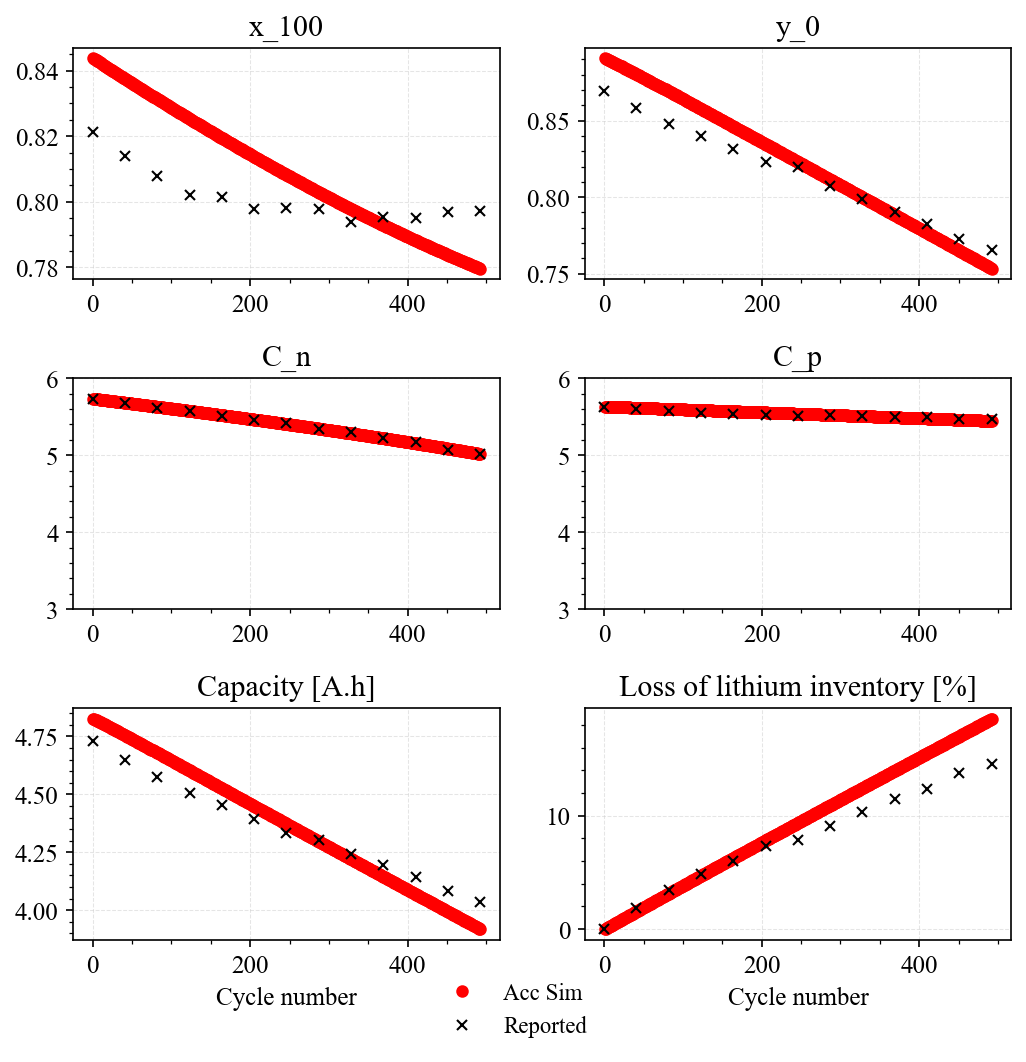

In [135]:
fig = plotc(all_sumvars_dict,dfe);
plt.savefig(fig_DIR +'comp_sim_cell_all_same_'+cell_no+'_eSOH.png')

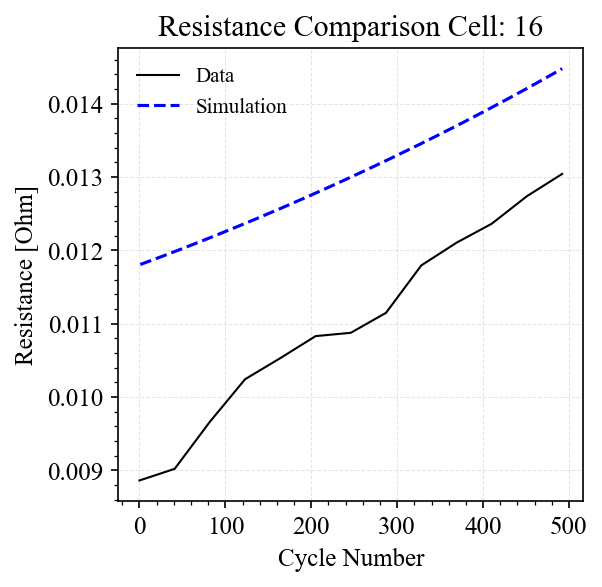

In [136]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
cell_not = f'{cell:02d}'
ax.plot(dfe['N'],dfe['Rs_ave'],'k',linewidth=1)
ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict["Local ECM resistance [Ohm]"],'b--',linewidth=1.5)
ax.set_xlabel('Cycle Number')
ax.set_ylabel('Resistance [Ohm]')
ax.set_title('Resistance Comparison Cell: '+cell_not)
ax.legend(["Data"] + ["Simulation"])
plt.savefig(fig_DIR +'comp_sim__cell_'+cell_no+'_resistance.png')

In [137]:
fdfd

NameError: name 'fdfd' is not defined

In [ ]:
dis_set = " until 3V"
c_rate_d = 'C/20'
c_rate_c = 'C/20'
experiment_rev_exp = pybamm.Experiment(
    [
        "Discharge at "+c_rate_d+dis_set,
        "Rest for 60 min",
        "Charge at "+c_rate_c+" until 4.2V", 
        # "Hold at 4.2V until C/50"
    ],
)
Ns = np.insert(N[1:]-1,0,0)
# Ns = N

In [ ]:
# for key in all_sumvars_dict.keys():
#     print(key)

In [ ]:
def rev_exp(cyc_no,eSOH,eSOH_data):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
    Cp = eSOH["C_p"][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.c_n_max)
    c_p_max = parameter_values.evaluate(param.c_p_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.L_n * param.c_n_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.L_p * param.c_p_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
    # Q_filt = ((Q/max(Q))>0.15)
    # int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
    # rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    # V_err = Vt*Q_filt-int_V(Q)*Q_filt
    # V_max_loc = np.argmax(abs(V_err))
    # V_err_Q = Q[V_max_loc]
    # V_err_max = V_err[V_max_loc]
    if max(Q)<max(eSOH_data['Q']):
        int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(Q))
        V_err = Vt-int_V(Q)
        max_V = abs(V_err[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = Q[V_max_loc]
        V_err_max = V_err[V_max_loc]
        int_E = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['E']-eSOH_data['E'].iloc[0],extrapolate=True)
        rmse_E = pybamm.rmse(exp,int_E(Q))
        E_err = exp-int_E(Q)
        max_E = abs(E_err[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = Q[E_max_loc]
        E_err_max = E_err[E_max_loc]
        Q_err = Q
    else:
        int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(eSOH_data['V'],int_V(eSOH_data['Q']))
        V_err = int_V(eSOH_data['Q'])-eSOH_data['V']
        max_V = abs(V_err.iloc[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = eSOH_data['Q'].iloc[V_max_loc]
        V_err_max = V_err.iloc[V_max_loc]
        int_E = interpolate.CubicSpline(Q,exp,extrapolate=True)
        rmse_E = pybamm.rmse(eSOH_data['E']-eSOH_data['E'].iloc[0],int_E(eSOH_data['Q']))
        E_err = int_E(eSOH_data['Q'])-eSOH_data['E']+eSOH_data['E'].iloc[0]
        max_E = abs(E_err.iloc[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = eSOH_data['Q'].iloc[E_max_loc]
        E_err_max = E_err.iloc[E_max_loc]
        Q_err = eSOH_data['Q']
    return Q,Vt,exp,rmse_V,rmse_E,max_V,max_E

In [ ]:
# i = 0
# rmse_V_l = []
# rmse_E_l = []
# max_V_l = []
# max_E_l = []
# fig, axes = plt.subplots(2,2,figsize=(10,6))
# # for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
# # for cyc_no in range(len(N)):
# for cyc_no in [0,1]:
#     # cyc_no=0
#     dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
#     Q,Vt,exp,rmse_V,rmse_E,max_V,max_E = rev_exp(cyc_no,all_sumvars_dict,dfo)
#     rmse_V_l = np.append(rmse_V_l,rmse_V)
#     rmse_E_l = np.append(rmse_E_l,rmse_E)
#     max_V_l = np.append(max_V_l,max_V)
#     max_E_l = np.append(max_E_l,max_E)
#     # if cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
#     if cyc_no in [0,1]:
#         ax1 = axes.flat[i]
#         ax1.plot(dfo['Q'],dfo['E']-dfo['E'].iloc[0],'k',linewidth=1)
#         ax1.plot(Q,exp,'b--',linewidth=1.5)
#         ax1.set_ylim([0,110])
#         ax1.set_xlim([0,5.1])
#         ax1.set_xticklabels([])
#         ax1.set_title('N = {}'.format(N[cyc_no]))
#         ax1.text(0.1,0.9,f'RMSE: {rmse_E:0.1f} $\mu$m',transform=ax1.transAxes)
#         ax2 = axes.flat[i+2]
#         ax2.plot(dfo['Q'],dfo['V'],'k',linewidth=1)
#         ax2.plot(Q,Vt,'b--',linewidth=1.5)
#         ax2.set_ylim([3,4.2])
#         ax2.set_xlim([0,5.1])
#         ax2.set_xlabel('Q [Ah]')
#         ax2.text(0.5,0.1,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
#         if i ==0:
#             ax2.set_ylabel('$V_t$ [Ah]')
#             ax1.set_ylabel('$\Delta$t [$\mu$m]')
#         i+=1
# fig.suptitle('Cell = '+cell_no)
# fig.tight_layout()
# plt.savefig(fig_DIR +'comp_sim_cell_all_same_'+cell_no+'.png')

In [ ]:
i = 0
rmse_V_l = []
rmse_E_l = []
max_V_l = []
max_E_l = []
fig, axes = plt.subplots(2,3,figsize=(10,6))
# for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
for cyc_no in range(len(N)):
    # cyc_no=0
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    Q,Vt,exp,rmse_V,rmse_E,max_V,max_E = rev_exp(cyc_no,all_sumvars_dict,dfo)
    rmse_V_l = np.append(rmse_V_l,rmse_V)
    rmse_E_l = np.append(rmse_E_l,rmse_E)
    max_V_l = np.append(max_V_l,max_V)
    max_E_l = np.append(max_E_l,max_E)
    if cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
        ax1 = axes.flat[i]
        ax1.plot(dfo['Q'],dfo['E']-dfo['E'].iloc[0],'k',linewidth=1)
        ax1.plot(Q,exp,'b--',linewidth=1.5)
        ax1.set_ylim([0,110])
        ax1.set_xlim([0,5.1])
        ax1.set_xticklabels([])
        ax1.set_title('N = {}'.format(N[cyc_no]))
        ax1.text(0.1,0.9,f'RMSE: {rmse_E:0.1f} $\mu$m',transform=ax1.transAxes)
        ax2 = axes.flat[i+3]
        ax2.plot(dfo['Q'],dfo['V'],'k',linewidth=1)
        ax2.plot(Q,Vt,'b--',linewidth=1.5)
        ax2.set_ylim([3,4.2])
        ax2.set_xlim([0,5.1])
        ax2.set_xlabel('Q [Ah]')
        ax2.text(0.5,0.1,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
        if i ==0:
            ax2.set_ylabel('$V_t$ [Ah]')
            ax1.set_ylabel('$\Delta$t [$\mu$m]')
        i+=1
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
plt.savefig(fig_DIR +'comp_sim_cell_all_same_'+cell_no+'.png')

In [ ]:
xZxZxZx

In [ ]:
# i = 0
# for cyc_no in range(len(N)):
#     # cyc_no=0
#     fig, ax = plt.subplots(1,1,figsize=(4,4))
#     dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
#     Q,Vt,exp,rmse_V,rmse_E,max_V,max_E = rev_exp(cyc_no,all_sumvars_dict,dfo)
#     # ax.plot(dfo['Q'],dfo['V'],'k',linewidth=1)
#     # ax.plot(Q,Vt,'b--',linewidth=1.5)
#     ax.plot(dfo['Q'],dfo['E']-dfo['E'].iloc[0],'k',linewidth=1)
#     ax.plot(Q,exp,'b--',linewidth=1.5)
#     # ax.set_ylim([3,4.2])
#     ax.set_xlim([0,5.1])
#     ax.set_xlabel('Q [Ah]')
#     ax.set_title('N = {}'.format(N[cyc_no]))
#     # ax.text(0.5,0.1,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax.transAxes)
# fig.tight_layout()

In [ ]:
Cap = dfe['Cap']
Irrev_exp = dfe['irrev_exp']
del_sei = all_sumvars_dict['X-averaged SEI thickness [m]'][Ns]
dfe['irrev_mod'] =30e6*3*del_sei*dfe['C_n']*parameter_values.evaluate(3600/(param.R_n_typ * param.c_n_max * param.F* param.A_cc))
irrev_mod = dfe['irrev_mod']

In [ ]:
df_error = pd.DataFrame(
    {'N':N,'Cap':Cap,'Irrev_exp':Irrev_exp,'irrev_mod':irrev_mod,'del_sei':del_sei ,'rmse_V':rmse_V_l*1000,'rmse_E':rmse_E_l,'max_V':max_V_l*1000,'max_E':max_E_l}
)
df_error.to_csv(res_DIR + "comp_sim_cell_"+cell_no+".csv", index=False)

In [ ]:
df_error.head()

In [ ]:
drfsdsdfgsd

# Plots

## Plot RMSE Summary

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
cells = np.arange(1,19,3)
for cellt in cells:
    cell_not = f'{cellt:02d}'
    df_t = pd.read_csv(res_DIR + "comp_sim_cell_"+cell_not+".csv")
    if cellt in [13,16]:
        df_t['N']=df_t['N']/2
    ax.plot(df_t['N'],df_t['rmse_V'])
    # ax.set_ylim([0,30])
ax.legend(['1','4','7','10','13','16'])
ax.set_ylabel('$V_t$   error [mV]')
ax.set_xlabel('Eq. Full Cycles')
ax.set_title('RMSE in Voltage')
plt.savefig(fig_DIR +'comp_sim_cell_volt_rmse'+'.png')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
cells = np.arange(1,19,3)
for cellt in cells:
    cell_not = f'{cellt:02d}'
    df_t = pd.read_csv(res_DIR + "comp_sim_cell_"+cell_not+".csv")
    if cellt in [13,16]:
        df_t['N']=df_t['N']/2
    ax.plot(df_t['N'],df_t['rmse_E'])
    # ax.set_ylim([0,30])
ax.legend(['1','4','7','10','13','16'])
ax.set_ylabel('$\Delta$t   error [$\mu$m]')
ax.set_xlabel('Eq. Full Cycles')
ax.set_title('RMSE in Expansion')
plt.savefig(fig_DIR +'comp_sim_cell_exp-rmse'+'.png')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
cells = np.arange(1,19,3)
for cellt in cells:
    cell_not = f'{cellt:02d}'
    df_t = pd.read_csv(res_DIR + "comp_sim_cell_"+cell_not+".csv")
    df_t.head()
    if cellt in [13,16]:
        df_t['N']=df_t['N']/2
    ax.plot(df_t['Irrev_exp'],df_t['rmse_E'])
    # ax.set_ylim([0,30])
ax.legend(['1','4','7','10','13','16'])
ax.set_ylabel('$\Delta$t   error [$\mu$m]')
ax.set_xlabel('Irreversible Expansion [$\mu$m]')
ax.set_title('RMSE in Expansion')
plt.savefig(fig_DIR +'comp_sim_cell_exp-rmse_irr'+'.png')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
cells = np.arange(1,19,3)
for cellt in cells:
    cell_not = f'{cellt:02d}'
    df_t = pd.read_csv(res_DIR + "comp_sim_cell_"+cell_not+".csv")
    df_t.head()
    if cellt in [13,16]:
        df_t['N']=df_t['N']/2
    ax.plot(df_t['Cap'],df_t['rmse_E'])
    # ax.set_ylim([0,30])
ax.legend(['1','4','7','10','13','16'])
ax.invert_xaxis()
ax.set_ylabel('$\Delta$t   error [$\mu$m]')
ax.set_xlabel('Capacity [Ah]')
ax.set_title('RMSE in Expansion')
plt.savefig(fig_DIR +'comp_sim_cell_exp-rmse_cap'+'.png')

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,6))
ax1 = ax.flat[0]
ax2 = ax.flat[1]
cells = np.arange(1,19,3)
for cellt in cells:
    cell_not = f'{cellt:02d}'
    df_t = pd.read_csv(res_DIR + "comp_sim_cell_"+cell_not+".csv")
    if cellt in [13,16]:
        df_t['N']=df_t['N']/2
    ax1.plot(df_t['N'],df_t['Irrev_exp'])
    ax2.plot(df_t['N'],df_t['del_sei']*1e9)
    # ax.set_ylim([0,30])
ax1.legend(['1','4','7','10','13','16'])
ax1.set_ylabel('Irrev Exp Data [$\mu$m]')
ax1.set_xlabel('Eq. Full Cycles')
ax1.set_title('Irreversible Expansion')
ax2.set_ylabel('$delta_\mathrm{SEI}$ [nm]')
ax2.set_xlabel('Eq. Full Cycles')
ax2.set_title('SEI Layer Thickness')
fig.tight_layout()
plt.savefig(fig_DIR +'comp_sim_cell_irr_exp_sei'+'.png')

In [ ]:
cells = np.arange(1,19,3)
for cellt in cells:
    cell_not = f'{cellt:02d}'
    df_t = pd.read_csv(res_DIR + "comp_sim_cell_"+cell_not+".csv")
    if cellt in [13,16]:
        df_t['N']=df_t['N']/2
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    ax.plot(df_t['N'],df_t['Irrev_exp'])
    ax.plot(df_t['N'],df_t['irrev_mod'])
    ax.legend(['data','model'])
    ax.set_ylabel('Irrev Exp [$\mu$m]')
    ax.set_xlabel('Eq. Full Cycles')
    ax.set_title('Irrev Exp Comp Cell = '+cell_not)
    fig.tight_layout()
    plt.savefig(fig_DIR +'comp_sim_cell_irr_exp_'+cell_not+'.png')

## Plot Error at End of Charge

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
cells = np.arange(1,19,3)
for cellt in cells:
    cell_not = f'{cellt:02d}'
    df_t = pd.read_csv(res_DIR + "comp_sim_cell_"+cell_not+".csv")
    if cellt in [13,16]:
        df_t['N']=df_t['N']/2
    ax.plot(df_t['N'],df_t['max_V'])
    # ax.set_ylim([0,30])
ax.legend(['1','4','7','10','13','16'])
ax.set_ylabel('$V_t$   error [mV]')
ax.set_xlabel('Eq. Full Cycles')
ax.set_title('Error at End of Charge Voltage')
plt.savefig(fig_DIR +'comp_sim_cell_volt_max'+'.png')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
cells = np.arange(1,19,3)
for cellt in cells:
    cell_not = f'{cellt:02d}'
    df_t = pd.read_csv(res_DIR + "comp_sim_cell_"+cell_not+".csv")
    if cellt in [13,16]:
        df_t['N']=df_t['N']/2
    ax.plot(df_t['N'],df_t['max_E'])
    # ax.set_ylim([0,30])
ax.legend(['1','4','7','10','13','16'])
ax.set_ylabel('$\Delta$t   error [$\mu$m]')
ax.set_xlabel('Eq. Full Cycles')
ax.set_title('Error at End of Charge Expansion')
plt.savefig(fig_DIR +'comp_sim_cell_exp_max'+'.png')

# Debug

In [ ]:
cyc_no=7
eSOH=all_sumvars_dict
dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
eSOH_data=dfo
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
model = spm
Vmin = 3.0
Vmax = 4.2
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
param = model.param
Cn = eSOH["C_n"][Ns[cyc_no]]
# print(Cn)
Cp = eSOH["C_p"][Ns[cyc_no]]
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)
n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
eps_n_data = parameter_values.evaluate(Cn*3600/(param.L_n * param.c_n_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(Cp*3600/(param.L_p * param.c_p_max * param.F* param.A_cc))

esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
    solver=pybamm.AlgebraicSolver(),
)

parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
    "x_100"
        ].data[0]
        * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
            "y_100"
        ].data[0]
        * c_p_max,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        
    }
)

sim_exp = pybamm.Simulation(
    model, experiment=experiment_rev_exp, parameter_values=parameter_values,
    solver=pybamm.CasadiSolver("safe")
)
sol_exp = sim_exp.solve()
t_t = sol_exp["Time [min]"].entries
I_t = sol_exp["Current [A]"].entries
Q_t = -sol_exp['Discharge capacity [A.h]'].entries
Vt_t = sol_exp["Terminal voltage [V]"].entries
exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
idx = np.where(np.diff(np.sign(I_t)))[0]
I = I_t[idx[-1]:]
t = t_t[idx[-1]:]-t_t[idx[-1]]
Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
Vt = Vt_t[idx[-1]:]
exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
# Q_filt = ((Q/max(Q))>0.15)
# int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
# rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
# V_err = Vt*Q_filt-int_V(Q)*Q_filt
# V_max_loc = np.argmax(abs(V_err))
# V_err_Q = Q[V_max_loc]
# V_err_max = V_err[V_max_loc]
if max(Q)<max(eSOH_data['Q']):
    int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
    rmse_V = pybamm.rmse(Vt,int_V(Q))
    V_err = Vt-int_V(Q)
    max_V = abs(V_err[-2])
    V_max_loc = np.argmax(abs(V_err))
    V_err_Q = Q[V_max_loc]
    V_err_max = V_err[V_max_loc]
    int_E = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['E']-eSOH_data['E'].iloc[0],extrapolate=True)
    rmse_E = pybamm.rmse(exp,int_E(Q))
    E_err = exp-int_E(Q)
    max_E = abs(E_err[-2])
    E_max_loc = np.argmax(abs(E_err))
    E_err_Q = Q[E_max_loc]
    E_err_max = E_err[E_max_loc]
    Q_err = Q
else:
    int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
    rmse_V = pybamm.rmse(eSOH_data['V'],int_V(eSOH_data['Q']))
    V_err = int_V(eSOH_data['Q'])-eSOH_data['V']
    max_V = abs(V_err.iloc[-2])
    V_max_loc = np.argmax(abs(V_err))
    V_err_Q = eSOH_data['Q'].iloc[V_max_loc]
    V_err_max = V_err.iloc[V_max_loc]
    int_E = interpolate.CubicSpline(Q,exp,extrapolate=True)
    rmse_E = pybamm.rmse(eSOH_data['E']-eSOH_data['E'].iloc[0],int_E(eSOH_data['Q']))
    E_err = int_E(eSOH_data['Q'])-eSOH_data['E']+eSOH_data['E'].iloc[0]
    max_E = abs(E_err.iloc[-2])
    E_max_loc = np.argmax(abs(E_err))
    E_err_Q = eSOH_data['Q'].iloc[E_max_loc]
    E_err_max = E_err.iloc[E_max_loc]
    Q_err = eSOH_data['Q']


In [ ]:
fig, ax = plt.subplots(2,1,figsize=(4,4))
ax1 = ax.flat[0]
ax1.plot(dfo['Q'],dfo['V'],'k',linewidth=1)
ax1.plot(Q,Vt,'b--',linewidth=1.5)
ax2 = ax.flat[1]
ax2.plot(dfo['Q'],dfo['E']-dfo['E'].iloc[0],'k',linewidth=1)
ax2.plot(Q,exp,'b--',linewidth=1.5)